In [22]:
from preprocessing import OCRPreprocessor
from matplotlib import pyplot as plt
import fitz
from PIL import Image
from matplotlib.patches import Rectangle
import numpy as np

from ocr import OCR
from model import LayoutLM_QA_Model

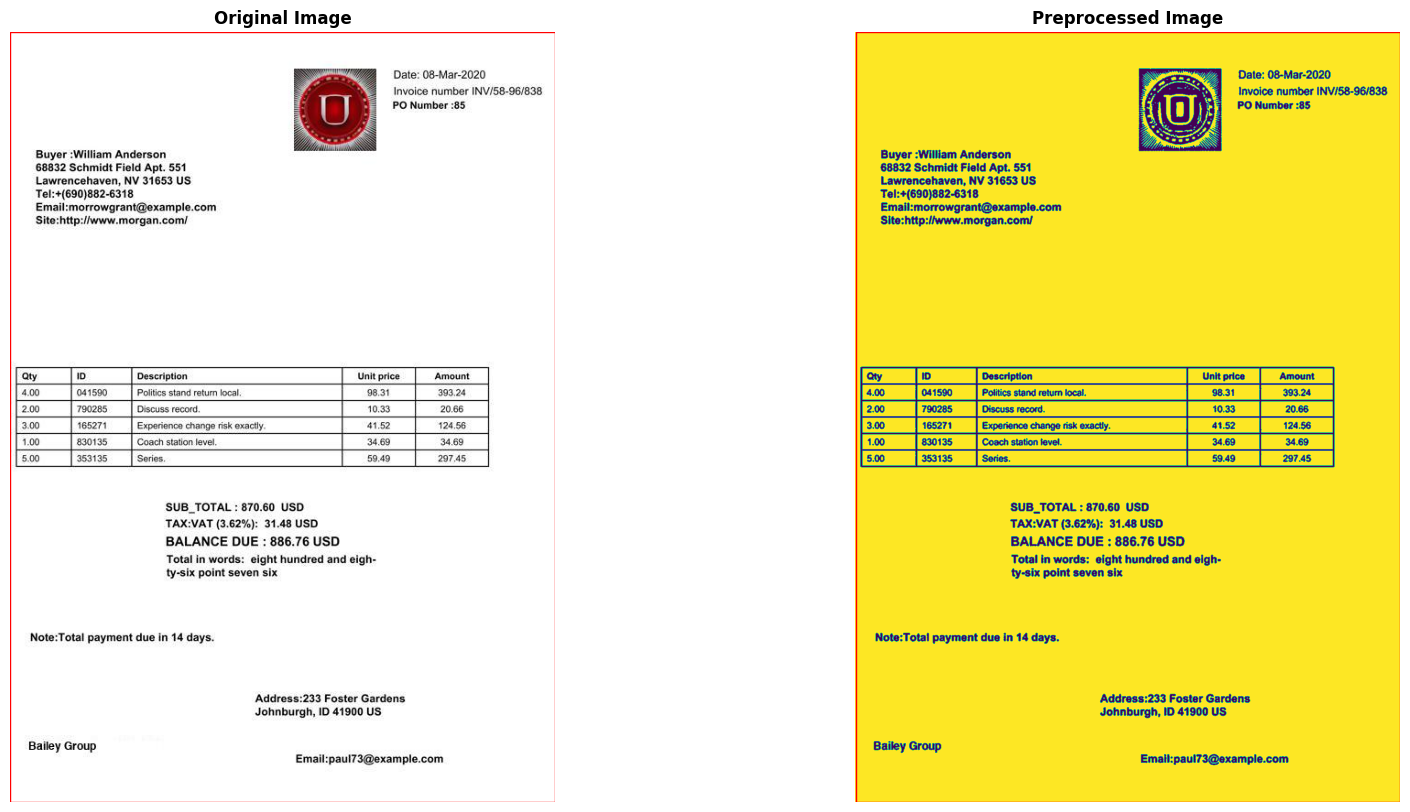

In [38]:
img_path = 'images/Template5_Instance73.jpg'
original_image = Image.open(img_path)

# Load and preprocess the image for OCR
prp = OCRPreprocessor()
prp_image = prp.process_image_for_ocr(img_path)

# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
rect = Rectangle((0, 0), original_image.width, original_image.height, edgecolor='red', linewidth=1, fill=False)
axes[0].add_patch(rect)

# Plot the preprocessed image
axes[1].imshow(prp_image)
axes[1].set_title('Preprocessed Image')
axes[1].axis('off')
rect = Rectangle((0, 0), prp_image.shape[1], prp_image.shape[0], edgecolor='red', linewidth=1, fill=False)
axes[1].add_patch(rect)

plt.show()


In [40]:
img_path = 'images/Template5_Instance73.jpg'

preprocessor = OCRPreprocessor()
ocr = OCR("C:/Program Files/Tesseract-OCR/tessdata")
model = LayoutLM_QA_Model(preprocessor, ocr, img_path)

In [72]:
model.answer_question("What is the invoice number?")

' INV/58-96/838'